# Part 2: MLP

In this part of the assignment, you will complete a Do-It-Yourself (DIY) implementation of a multilayer perceptron (MLP), including code to optimize the network with backpropagation and minibatch stochastic gradient descent, that corresponds to the Scikit-Learn API.

**Learning objectives.** You will:
1. Write object-oriented code for a neural network class in Python class, matching standard API patterns.
2. Apply numerical Python (NumPy) to efficiently implement a multilayer perceptron with backpropagation and minibatch stochastic gradient descent. 
3. Evaluate your implementation compared to the Scikit-Learn standard on real image data. 

The following code imports a dataset consisting of 8 by 8 pixel grayscale images of handwritten digits. Some images are visualized and then the data are flattened into 64-value one-dimensional NumPy arrays before splitting into training and testing sets.

(1797, 64)


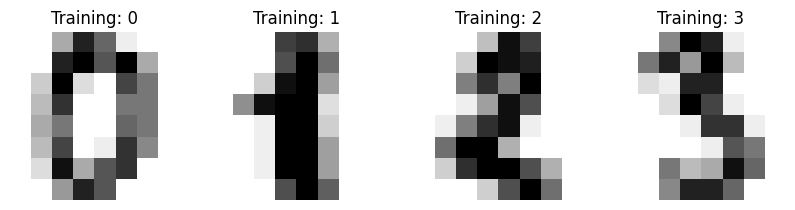

In [1]:
# Run but DO NOT MODIFY this code

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

digits = load_digits()
print(digits.data.shape)

# visualizing examples
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.3, shuffle=False
    )

## Task 1

Using Scikit-Learn, build a [multilayer perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) fit on the training data to predict the value of `y` given `X`. You may need to experiment with different numbers of hidden units (you only need to have one hidden layer) or other training hyperparameters. Ensure that you achieve a **training** [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of at least 90%.   

Then evaluate and report the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model on the **test** data.

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(7,), activation='relu', max_iter=2000, random_state=2024)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

y_test_pred = mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
Training Accuracy: 1.0
Test Accuracy: 0.8722222222222222


## Task 2

Implement a do it yourself (DIY) multilayer perceptron classifier following the Scikit-Learn API by completing the `NeuralNet` class below. 

You will see in the description of the class that we are suggesting a somewhat atypical architecture consisting of a single hidden layer with hyperbolic tangent activation followed by linear output, trained on the sum of squares loss. This is to simplify the implementation and align it with the simple example of backpropagation shown in the [Bishop Deep Learning Book](https://www.bishopbook.com/) Section 8.1.3 (meaning you do not need to derive the derivatives for backpropagation yourself and are invited to implement the derivations from the book).

Some important notes about the implementation:

1. Remember that the Scikit-Learn API treats an input `X` array, whether to `fit` or `predict`, as a matrix with a row for every data point and a column for every feature. 
2. For `fit`, every row in `X` corresponds to a given output in `y`, and  you don't need to return anything, just optimize the internal model weights using minibatch stochastic gradient descent. Model weights should be stored as instance variables -- we recommend that you initialize these weights as random normally distributed values, for example by using NumPy's [random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html). You may wish to separately implement a `backprop` helper method to compute the gradient in order to simplify the code structure, but this is optional. 
3. For `predict_proba`, you should return a two-dimensional NumPy array with a row for every row in `X` and a column for every value in `0, 1, ..., out_size - 1` corresponding to the possible classes, where each entry in a given row corresponds to a probability the given row's input corresponds to the given column's class.
4. For `predict`, you should return a one-dimensional NumPy array with a single element `0, 1, ..., out_size - 1` per row in `X` corresponding to the class with the highest predicted probability.
5. You do **not** need to include a bias term for this implementation.
6. The `fit` method takes an optional `verbose` parameter. While it is not required, we highly recommend that you include code in the `fit` method that, when `verbose` is `True`, logs/prints more information about the training process to help debug. 
7. The `pass` statements are syntactic placeholders that should be removed when you implement a method.
8. Make sure to double check the shapes/dimensions of any matrices or vectors to confirm they align with your expectations.
9. Finally, note that your implementation will be much more efficient if you use vectorized NumPy operations and avoid for loops or nested for loops over large amounts of data.

In [4]:
class NeuralNet:
   
    def __init__(self, in_size, out_size, 
                 h_size=100, lr=0.01, batch_size=64,
                 epochs=2, random_state=2024):
        np.random.seed(random_state)
        self.in_size = in_size
        self.out_size = out_size
        self.h_size = h_size
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        
        # initialize the weights
        self.W1 = np.random.normal(0, 0.1, (in_size, h_size))
        self.W2 = np.random.normal(0, 0.1, (h_size, out_size))
    
    def forward(self, X):
        self.a1 = X @ self.W1
        self.z1 = np.tanh(self.a1)
        self.a2 = self.z1 @ self.W2
        return self.a2
    
    def backprop(self, X_batch, y_batch):
        logits = self.forward(X_batch)
        y_one_hot_encoded = np.eye(self.out_size)[y_batch]  
    
        grad_a2 = (logits - y_one_hot_encoded) / self.batch_size
        grad_W2 = self.z1.T @ grad_a2
        grad_z1 = grad_a2 @ self.W2.T
        grad_a1 = grad_z1 * (1 - self.z1**2)  # derivative of tanh activation
        grad_W1 = X_batch.T @ grad_a1
    
        return grad_W1, grad_W2
    
    def predict_proba(self, X):
        logits = self.forward(X)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
     
    def fit(self, X, y, verbose=False):
        for epoch in range(self.epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            for i in range(0, X.shape[0], self.batch_size):
                batch_index = indices[i:i+self.batch_size]
                X_batch, y_batch = X[batch_index], y[batch_index]
                
                grad_W1, grad_W2 = self.backprop(X_batch, y_batch)
                
                self.W2 -= self.lr * grad_W2
                self.W1 -= self.lr * grad_W1
                
            if verbose:
                acc = np.mean(self.predict(X) == y)
                print(f"Epoch {epoch+1}/{self.epochs}, Accuracy: {acc:.4f}")



## Task 3

Show that your `NeuralNet` class can effectively learn. Specifically fit an instance of your DIY model on the training data to predict the value of `y` given `X`. You may need to experiment with different numbers of hidden units (you only need to have one hidden layer) or other training hyperparameters. Ensure that you achieve a **training** [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of at least 70% (your implementation is not expected to achieve the same level of performance as the Scikit-Learn implementation, but should demonstrate the proof of concept).   

Then evaluate and report the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model on the **test** data.

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

nn = NeuralNet(in_size=X_train.shape[1], out_size=10, h_size=50, lr=0.01, batch_size=64, epochs=100)
nn.fit(X_train, y_train, verbose=True)

y_train_pred = nn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

y_test_pred = nn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/100, Accuracy: 0.2307
Epoch 2/100, Accuracy: 0.3286
Epoch 3/100, Accuracy: 0.4399
Epoch 4/100, Accuracy: 0.5259
Epoch 5/100, Accuracy: 0.5990
Epoch 6/100, Accuracy: 0.6523
Epoch 7/100, Accuracy: 0.6762
Epoch 8/100, Accuracy: 0.7049
Epoch 9/100, Accuracy: 0.7399
Epoch 10/100, Accuracy: 0.7407
Epoch 11/100, Accuracy: 0.7621
Epoch 12/100, Accuracy: 0.7765
Epoch 13/100, Accuracy: 0.7772
Epoch 14/100, Accuracy: 0.8003
Epoch 15/100, Accuracy: 0.8067
Epoch 16/100, Accuracy: 0.8107
Epoch 17/100, Accuracy: 0.8242
Epoch 18/100, Accuracy: 0.8075
Epoch 19/100, Accuracy: 0.8321
Epoch 20/100, Accuracy: 0.8425
Epoch 21/100, Accuracy: 0.8457
Epoch 22/100, Accuracy: 0.8536
Epoch 23/100, Accuracy: 0.8584
Epoch 24/100, Accuracy: 0.8687
Epoch 25/100, Accuracy: 0.8735
Epoch 26/100, Accuracy: 0.8759
Epoch 27/100, Accuracy: 0.8870
Epoch 28/100, Accuracy: 0.8934
Epoch 29/100, Accuracy: 0.9014
Epoch 30/100, Accuracy: 0.9014
Epoch 31/100, Accuracy: 0.9037
Epoch 32/100, Accuracy: 0.9085
Epoch 33/100, Acc